<a href="https://colab.research.google.com/github/Dharamchandpatle/Refinery-AIML/blob/main/EnergyConsumptionPredictionModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Energy Consumption Prediction Model
Energy Consumption & SEC Prediction (Prophet)





In [19]:
# Energy Consumption & SEC Prediction (Prophet)

In [20]:
!pip install prophet


In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from prophet import Prophet


In [22]:
# UPLOAD DATASET (AUTOMATION ENTRY POINT)

uploaded = files.upload()
file_name = list(uploaded.keys())[0]

df = pd.read_csv(file_name)
print("Dataset uploaded:", file_name)

df.head()


Saving refinery_energy_sec_historical_prophet.csv to refinery_energy_sec_historical_prophet (1).csv
Dataset uploaded: refinery_energy_sec_historical_prophet (1).csv


,date,unit_name,electricity_kwh,steam_usage,fuel_usage,production_tons,total_energy,SEC
0,2023-05-14,VDU,83125.631706,40467.258382,31706.675639,2226.394896,155299.565727,69.753828
1,2024-09-23,NCU,74461.747074,49193.090853,36614.940254,1745.696047,160269.778181,91.808524
2,2022-08-23,VDU,86488.229163,43082.102144,35285.831519,1832.380506,164856.162826,89.968302
3,2021-03-17,DCU,87440.036175,37464.336152,23749.437474,1334.705471,148653.809801,111.375740
4,2024-11-18,NCU,80752.097196,40834.855238,36930.883801,1499.356646,158517.836235,105.723903


In [23]:
# BASIC DATA CLEANING (REQUIRED)


# Remove duplicates
df.drop_duplicates(inplace=True)

# Handle date column safely
if "date" in df.columns:
    df["date"] = pd.to_datetime(df["date"])
elif "ds" in df.columns:
    df["ds"] = pd.to_datetime(df["ds"])

# Handle missing values
df.fillna(df.median(numeric_only=True), inplace=True)

# Clean only if raw refinery data
required_cols = ["electricity_kwh", "steam_usage", "fuel_usage", "production_tons"]
if all(col in df.columns for col in required_cols):
    df = df[
        (df["electricity_kwh"] > 0) &
        (df["steam_usage"] > 0) &
        (df["fuel_usage"] > 0) &
        (df["production_tons"] > 0)
    ]

print("Cleaning completed")

df.info()


Cleaning completed
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   date             1460 non-null   datetime64[ns]
 1   unit_name        1460 non-null   object        
 2   electricity_kwh  1460 non-null   float64       
 3   steam_usage      1460 non-null   float64       
 4   fuel_usage       1460 non-null   float64       
 5   production_tons  1460 non-null   float64       
 6   total_energy     1460 non-null   float64       
 7   SEC              1460 non-null   float64       
dtypes: datetime64[ns](1), float64(6), object(1)
memory usage: 91.4+ KB


In [24]:
# FEATURE ENGINEERING (VERY IMPORTANT)



# Total energy
df["total_energy"] = (
    df["electricity_kwh"] +
    df["steam_usage"] +
    df["fuel_usage"]
)

# SEC
df["SEC"] = df["total_energy"] / df["production_tons"]

df.head()


,date,unit_name,electricity_kwh,steam_usage,fuel_usage,production_tons,total_energy,SEC
0,2023-05-14,VDU,83125.631706,40467.258382,31706.675639,2226.394896,155299.565727,69.753828
1,2024-09-23,NCU,74461.747074,49193.090853,36614.940254,1745.696047,160269.778181,91.808524
2,2022-08-23,VDU,86488.229163,43082.102144,35285.831519,1832.380506,164856.162826,89.968302
3,2021-03-17,DCU,87440.036175,37464.336152,23749.437474,1334.705471,148653.809801,111.375740
4,2024-11-18,NCU,80752.097196,40834.855238,36930.883801,1499.356646,158517.836235,105.723903


In [25]:
# AGGREGATE DATA (TIME-SERIES FORMAT)
# Daily aggregation (best for refinery planning)


daily_df = df.groupby("date").agg({
    "total_energy": "sum",
    "SEC": "mean"
}).reset_index()

daily_df.head()


,date,total_energy,SEC
0,2021-01-02,331520.515792,113.107205
1,2021-01-04,187421.636096,134.722069
2,2021-01-05,194059.217732,98.370001
3,2021-01-06,163622.819708,79.454921
4,2021-01-09,508448.253530,95.146223


In [26]:
# PREPARE DATA FOR PROPHET (FORMAT RULE)
# Prophet requires:
# ds → date
# y → value to predict
# 🔹 ENERGY FORECAST DATASET

# TRAIN ENERGY CONSUMPTION MODEL


energy_ts = daily_df.rename(columns={
    "date": "ds",
    "total_energy": "y"
})

energy_model = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=True,
    changepoint_prior_scale=0.1
)

energy_model.fit(energy_ts)



INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [27]:

# FORECAST FUTURE ENERGY (NEXT 30 DAYS)


future_energy = energy_model.make_future_dataframe(periods=30)
energy_forecast = energy_model.predict(future_energy)


energy_forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2021-01-02,246647.224515,82197.763542,425750.096429,246647.224515,246647.224515,1967.043519,1967.043519,1967.043519,6400.664103,6400.664103,6400.664103,-4433.620583,-4433.620583,-4433.620583,0.0,0.0,0.0,248614.268035
1,2021-01-04,246746.552690,49603.456253,412062.144395,246746.552690,246746.552690,-14386.122393,-14386.122393,-14386.122393,-13955.982954,-13955.982954,-13955.982954,-430.139439,-430.139439,-430.139439,0.0,0.0,0.0,232360.430297
2,2021-01-05,246796.216777,68675.613750,426020.180450,246796.216777,246796.216777,-4628.790380,-4628.790380,-4628.790380,-6454.626536,-6454.626536,-6454.626536,1825.836156,1825.836156,1825.836156,0.0,0.0,0.0,242167.426397
3,2021-01-06,246845.880865,94565.850280,444016.285462,246845.880865,246845.880865,16128.438910,16128.438910,16128.438910,11961.157532,11961.157532,11961.157532,4167.281378,4167.281378,4167.281378,0.0,0.0,0.0,262974.319774
4,2021-01-09,246994.873126,76419.771012,440794.926157,246994.873126,246994.873126,17406.110485,17406.110485,17406.110485,6400.664103,6400.664103,6400.664103,11005.446382,11005.446382,11005.446382,0.0,0.0,0.0,264400.983612


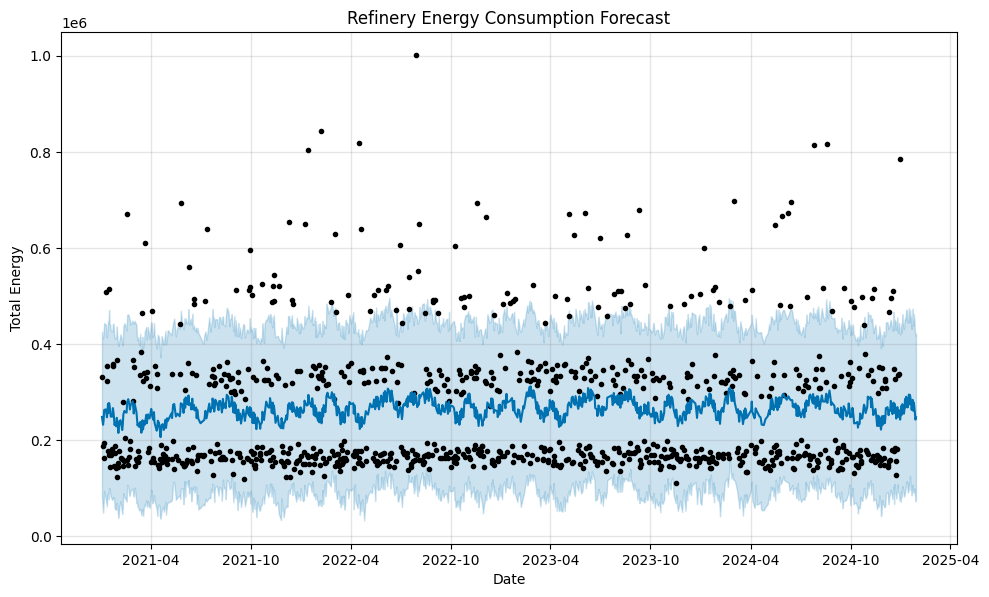

In [28]:
# VISUALIZE ENERGY FORECAST 📊


energy_model.plot(energy_forecast)
plt.title("Refinery Energy Consumption Forecast")
plt.xlabel("Date")
plt.ylabel("Total Energy")
plt.show()

In [29]:
# PREPARE SEC FORECAST DATASET

# SEC FORECAST MODEL (AUTO)


sec_ts = daily_df.rename(columns={
    "date": "ds",
    "SEC": "y"
})

sec_model = Prophet(
    yearly_seasonality=True,
    changepoint_prior_scale=0.1
)

sec_model.fit(sec_ts)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


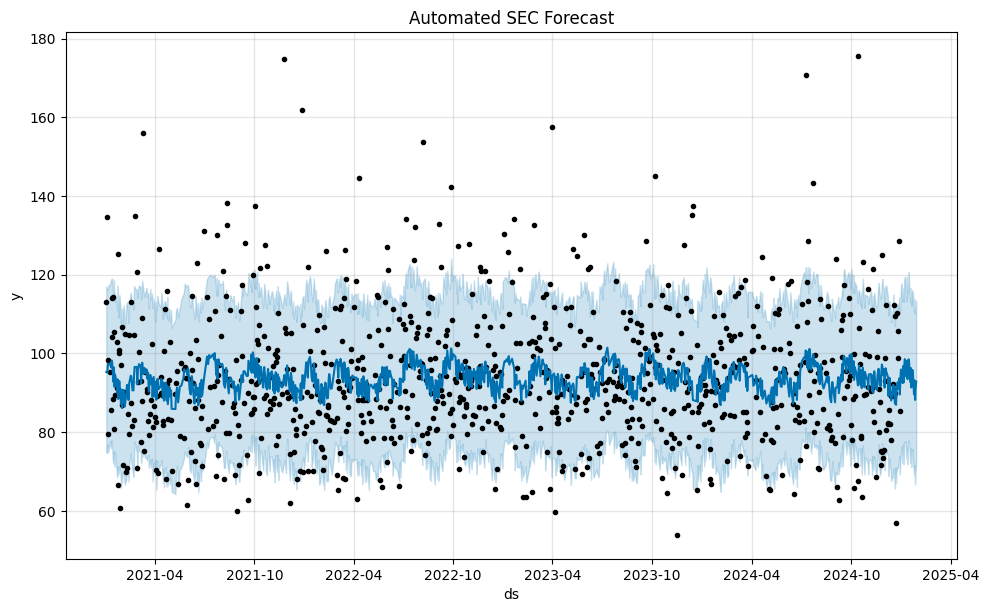

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2021-01-02,92.754716,74.862679,116.954918,92.754716,92.754716,2.515639,2.515639,2.515639,1.441392,1.441392,1.441392,1.074246,1.074246,1.074246,0.0,0.0,0.0,95.270355
1,2021-01-04,92.759115,74.599915,116.416164,92.759115,92.759115,2.360138,2.360138,2.360138,0.457053,0.457053,0.457053,1.903085,1.903085,1.903085,0.0,0.0,0.0,95.119253
2,2021-01-05,92.761315,76.781803,116.110849,92.761315,92.761315,4.543798,4.543798,4.543798,2.286667,2.286667,2.286667,2.257131,2.257131,2.257131,0.0,0.0,0.0,97.305113
3,2021-01-06,92.763514,74.968217,117.347331,92.763514,92.763514,4.329460,4.329460,4.329460,1.768047,1.768047,1.768047,2.561413,2.561413,2.561413,0.0,0.0,0.0,97.092974
4,2021-01-09,92.770113,77.730946,117.508856,92.770113,92.770113,4.563869,4.563869,4.563869,1.441392,1.441392,1.441392,3.122477,3.122477,3.122477,0.0,0.0,0.0,97.333982


In [30]:
# FORECAST FUTURE SEC


# SEC FORECAST + VISUAL


future_sec = sec_model.make_future_dataframe(periods=30)
sec_forecast = sec_model.predict(future_sec)

sec_model.plot(sec_forecast)
plt.title("Automated SEC Forecast")
plt.show()

sec_forecast.head()

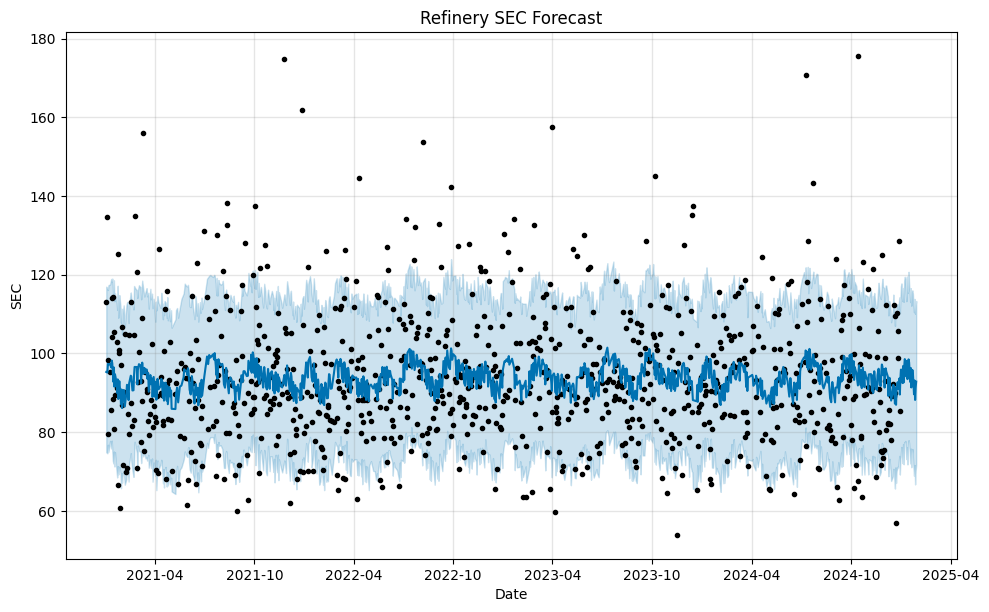

In [31]:
# VISUALIZE SEC FORECAST


sec_model.plot(sec_forecast)
plt.title("Refinery SEC Forecast")
plt.xlabel("Date")
plt.ylabel("SEC")
plt.show()

In [32]:
#AUTO SAVE OUTPUT FILES


energy_forecast[["ds", "yhat", "yhat_lower", "yhat_upper"]].to_csv(
    "energy_forecast.csv", index=False
)

sec_forecast[["ds", "yhat", "yhat_lower", "yhat_upper"]].to_csv(
    "sec_forecast.csv", index=False
)

print("Forecast files saved automatically")

Forecast files saved automatically


In [33]:
# DOWNLOAD RESULTS
# files.download("energy_forecast.csv")
# files.download("sec_forecast.csv")